In [1]:
import pandas as pd
import json
import re
import html
import string
import time
import numpy as np
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from collections import Counter
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from  sklearn.metrics  import accuracy_score, f1_score
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
additional_stop_words = ["like", "use", "good", "get",
                 "want", "fuck", "fucking","shit", "would", "something","one"]
stop_words.extend(additional_stop_words)

#Create the dictionary for the desired 4chan channel for which the datatset was created
channel_dict = {
    "technology":0,
    "television":1,
    "cooking":2,
    "literature":3
}
def remove_html_tags(sentence):
    sentence = html.unescape(sentence)
    sentence = sentence.replace("\\","")
    sentence = sentence.replace("\r"," ")
    sentence = sentence.replace("\n"," ")

    p = re.compile(r'\/\w+\/')
    sentence = re.sub(p,' ',sentence)

    p = re.compile('<.*?>')
    sentence= re.sub(p, ' ', str(sentence))

    sentence = re.sub(r'http\S+', '', sentence)
    return sentence

def preprocess(sentence, vocab):
    #remove HTML tags
    sentence = remove_html_tags(sentence)
    
    #remove numbers
    sentence = sentence.translate(sentence.maketrans('', '', '0123456789'))
    
    #remove punctuations and tokenize
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(sentence)
    
    #convert to lowercase
    tokens = [w.lower() for w in tokens]
        
    #remove stopwords
    tokens = [w for w in tokens if w not in stop_words]
    
    for tok in tokens:
        vocab[tok]+=1
    return ' '.join(tokens)

def load_data(filename, channel_type):
    with open(filename) as f:
        data = json.load(f)
        data = data['threads']
    post_list = []
    for thread in data:
        posts = thread['posts']
        for post in posts:
            dict_p = {}
            dict_p['threadid']=post['resto']
            dict_p['postid']=post['no']
            if 'com' in post:
                dict_p['comment']=post['com']
            if 'replies' in post:
                dict_p['replies']=post['replies']
            else:
                dict_p['replies']=0
            dict_p['timestamp']=post['time']
            dict_p['UTC_time']=datetime.fromtimestamp(post['time'])
            dict_p['channel_type']=channel_type
            post_list.append(dict_p)
    df = pd.DataFrame(post_list, columns=['threadid','postid','comment','replies', 'timestamp', 'UTC_time', "channel_type"])
    df=df.dropna()
    return df

# Top 15 most frequent words by channel
def plot_most_frequent_words(vocab, name):
    top_words = vocab.most_common(15)
    words = [w[0] for w in top_words]
    count = [w[1] for w in top_words]
    plt.figure(figsize=(12, 3))
    plt.title("Most common words -"+str(name))
    plt.bar(words,count,align='edge', width=0.5)

# Message count per thread(only OP)
def message_count_per_thread_op(df, name):
    df = df[df['threadid']==0]
    num_threads = len(df['replies'].values)
    plt.figure(figsize=(12, 3))
    plt.title("Message count per thread(only OP) - " + str(name))
    plt.bar(np.arange(num_threads),df['replies'].values)
    
# Message count per thread(excluding OP)
def message_count_per_thread_ex_op(df, name):
    post_counts = df[df['threadid']!=0].groupby('threadid').count()["postid"]
    plt.figure(figsize=(12, 3))
    plt.title("Message count per thread(excluding OP) - " + str(name))
    plt.bar(np.arange(len(post_counts.values)),post_counts.values,align='edge', width=0.5)
    
# Frequency of posts in a day(split in intervals of 1 hour)
def plot_freq_posts(df, name):
    freq = [v['UTC_time'].hour for k,v in df.iterrows()]
    plt.figure(figsize=(15, 3))
    plt.title("Frequency of posts (interval of 1 hour) - " + str(name))
    plt.xticks(np.arange(24))
    plt.hist(freq, bins=np.arange(24))

#Unique words per channel (channel signal):
def get_unique_words(vocab, vocab_combined, name):
    uniq_words = vocab.keys() - vocab_combined
    dict_g = {}
    for k,v in sorted(vocab.items(), key=lambda value: value[1], reverse=True):
        if k in uniq_words:
            dict_g[k]=v
    top_15_words = {k: dict_g[k] for k in list(dict_g)[:15]}
    plt.figure(figsize=(18, 3))
    plt.title("Unique words - " + str(name))
    plt.bar(top_15_words.keys(),top_15_words.values(),align='edge', width=0.5)
    return dict_g

In [3]:
#Load the data for the desired 4chan channels
#Technology
df_technology = load_data('technology.json', channel_dict["technology"])
vocab_technology = Counter({})
for idx, rows in df_technology.iterrows():
    df_technology.loc[idx,'processed_comments']=preprocess(rows['comment'], vocab_technology)
    
#TV
df_tv = load_data('television.json', channel_dict["television"])
vocab_tv = Counter({})
for idx, rows in df_tv.iterrows():
    df_tv.loc[idx,'processed_comments']=preprocess(rows['comment'], vocab_tv)
    
#Cooking
df_cooking = load_data('cooking.json', channel_dict["cooking"])
vocab_cooking = Counter({})
for idx, rows in df_cooking.iterrows():
    df_cooking.loc[idx,'processed_comments']=preprocess(rows['comment'], vocab_cooking)
    
#Technology
df_lit = load_data('literature.json', channel_dict["literature"])
vocab_lit = Counter({})
for idx, rows in df_lit.iterrows():
    df_lit.loc[idx,'processed_comments']=preprocess(rows['comment'], vocab_lit)

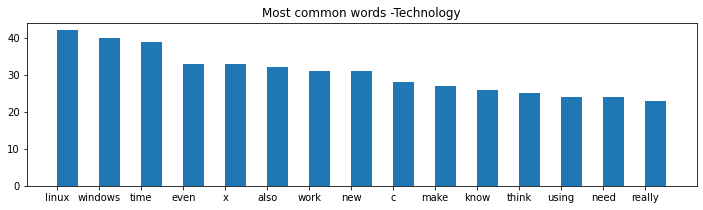

In [4]:
plot_most_frequent_words(vocab_technology, "Technology")
# Linux, windows are most frequent words in a Technology channel

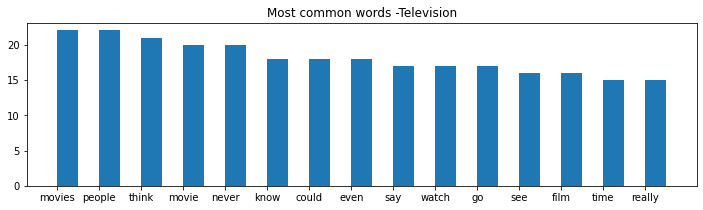

In [5]:
plot_most_frequent_words(vocab_tv, "Television")
# Movie, people are most frequent words in a Television channel

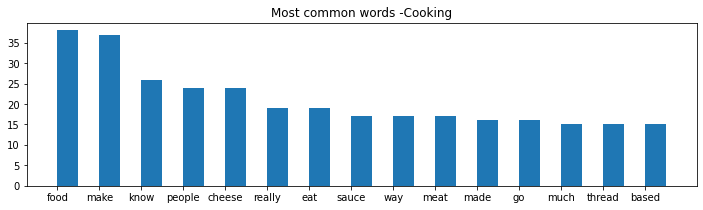

In [6]:
plot_most_frequent_words(vocab_cooking, "Cooking")
# Food, make are most frequent words in a Cooking channel

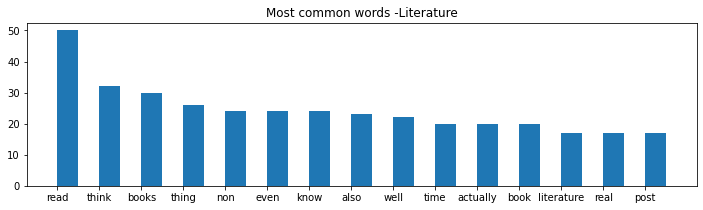

In [7]:
plot_most_frequent_words(vocab_lit, "Literature")
# Read, think are most frequent words in a Literature channel

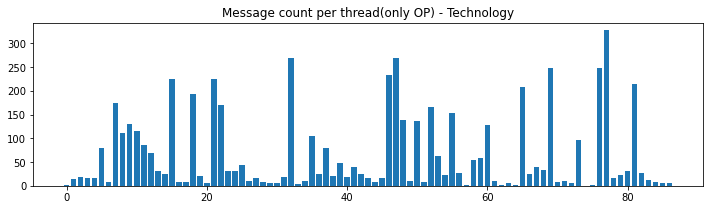

In [8]:
message_count_per_thread_op(df_technology, "Technology")

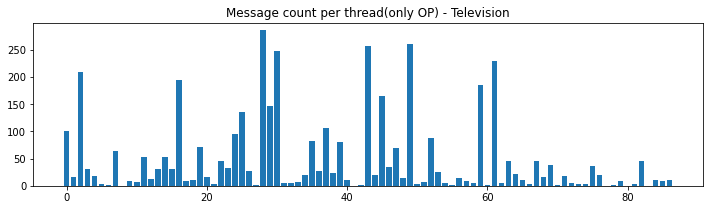

In [9]:
message_count_per_thread_op(df_tv, "Television")

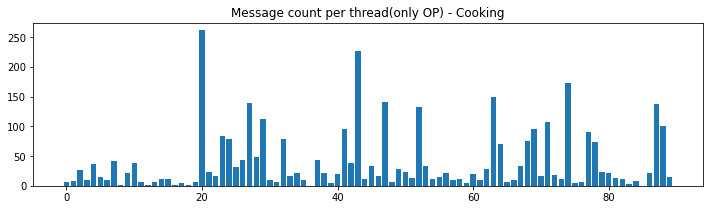

In [10]:
message_count_per_thread_op(df_cooking, "Cooking")

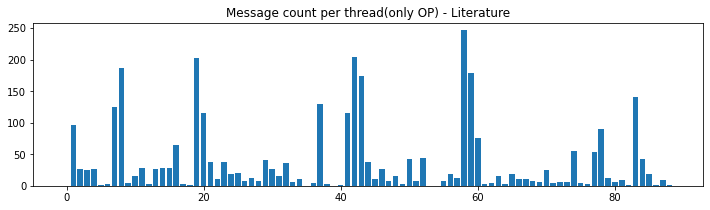

In [11]:
message_count_per_thread_op(df_lit, "Literature")

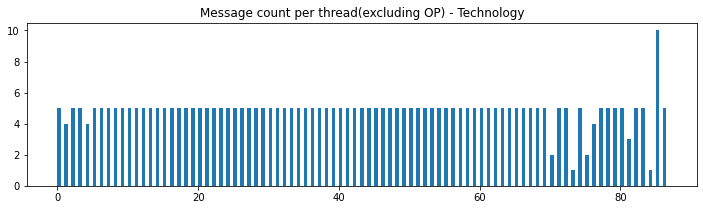

In [12]:
message_count_per_thread_ex_op(df_technology, "Technology")

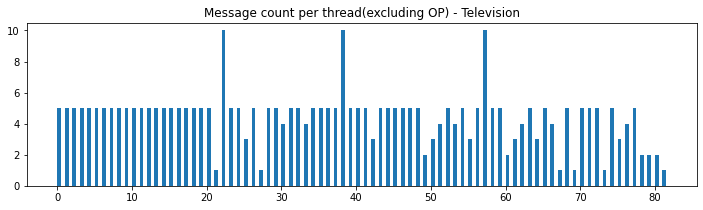

In [13]:
message_count_per_thread_ex_op(df_tv, "Television")

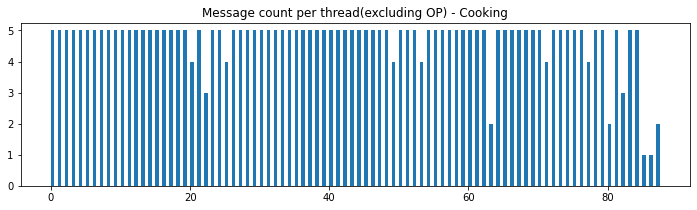

In [14]:
message_count_per_thread_ex_op(df_cooking, "Cooking")

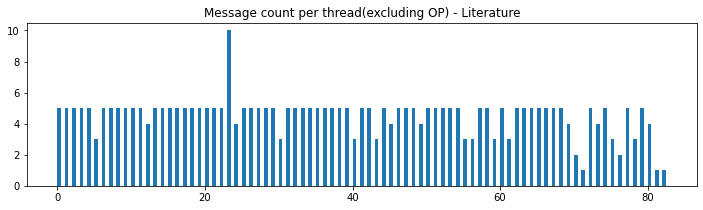

In [15]:
message_count_per_thread_ex_op(df_lit, "Literature")

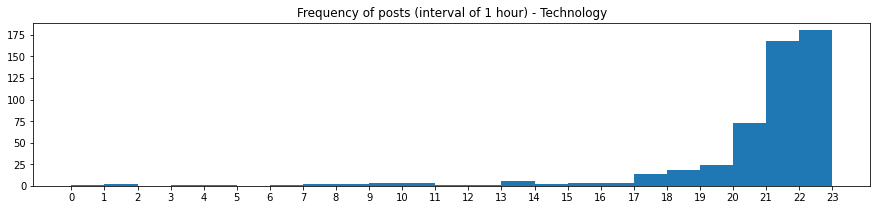

In [16]:
plot_freq_posts(df_technology, "Technology")

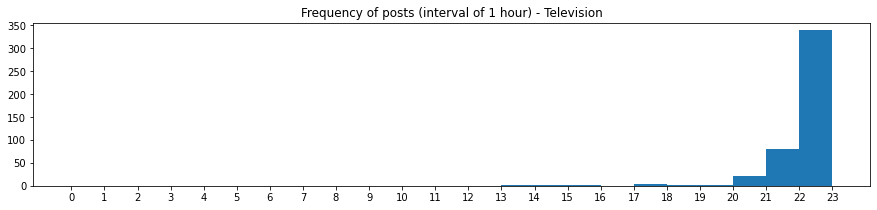

In [17]:
plot_freq_posts(df_tv, "Television")

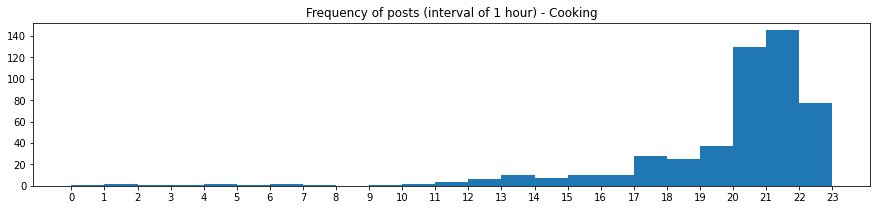

In [18]:
plot_freq_posts(df_cooking, "Cooking")

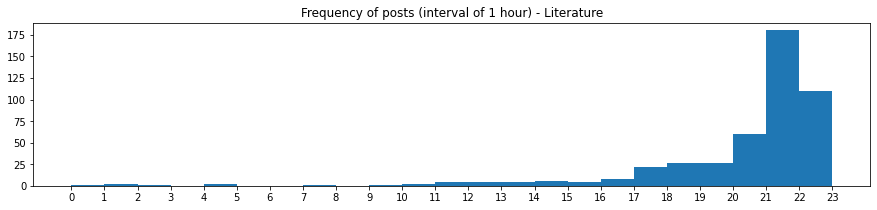

In [19]:
plot_freq_posts(df_lit, "Literature")

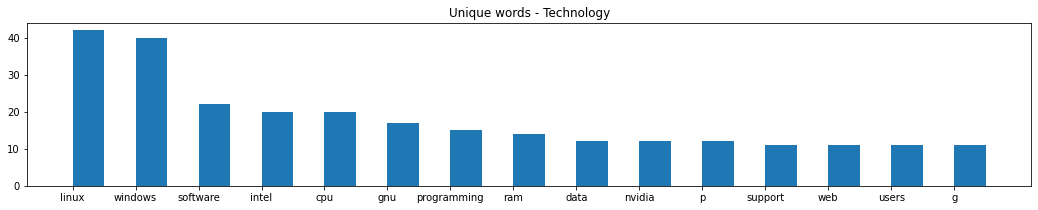

In [20]:
vocab_combined = set()
vocab_combined=vocab_combined.union(vocab_tv.keys(), vocab_cooking.keys(), vocab_lit.keys())
_ = get_unique_words(vocab_technology, vocab_combined, "Technology")

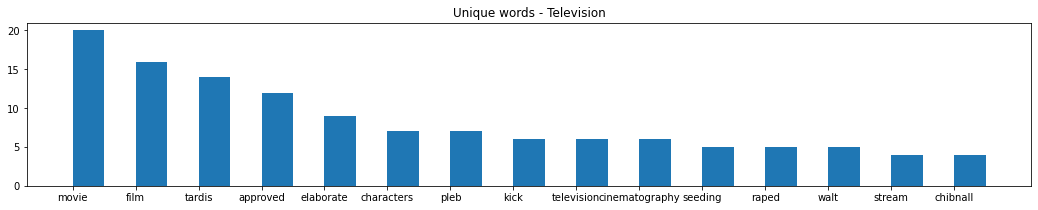

In [21]:
vocab_combined = set()
vocab_combined=vocab_combined.union(vocab_technology.keys(), vocab_cooking.keys(), vocab_lit.keys())
_ = get_unique_words(vocab_tv, vocab_combined, "Television")

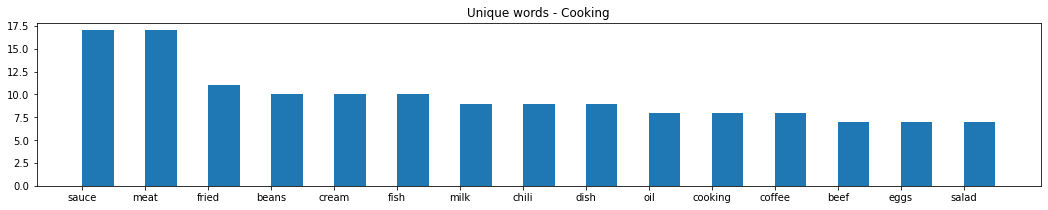

In [22]:
vocab_combined = set()
vocab_combined=vocab_combined.union(vocab_technology.keys(), vocab_tv.keys(), vocab_lit.keys())
_ = get_unique_words(vocab_cooking, vocab_combined, "Cooking")

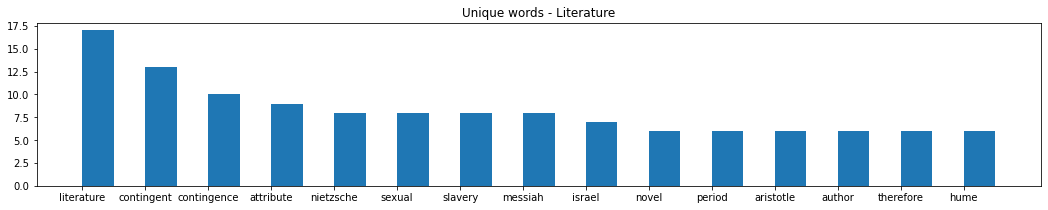

In [23]:
vocab_combined = set()
vocab_combined=vocab_combined.union(vocab_technology.keys(), vocab_tv.keys(), vocab_cooking.keys())
_ = get_unique_words(vocab_lit, vocab_combined, "Literature")

In [24]:
# Combining the dataframe for building a multi-class classifier
df_combined = df_technology[['processed_comments','channel_type']].copy()
df_combined = pd.concat([df_combined, df_tv[['processed_comments','channel_type']], df_cooking[['processed_comments','channel_type']], df_lit[['processed_comments','channel_type']]])

In [25]:
# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(df_combined['processed_comments'],df_combined['channel_type'], test_size=0.2)

#convert text to vectors
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

#Train the Model
clf = MultinomialNB(alpha=1.0).fit(train_vectors, y_train)

#Predict on the test set
predicted = clf.predict(test_vectors)

In [26]:
# Predict channel given the channel comments/posts
print('Accuracy score: ',accuracy_score(y_test,predicted))

Accuracy score:  0.6139896373056994
